# Assignment 1 
# Husky vs Wolf

--Names --

## Imports


In [1]:
from torch.utils.data import Dataset, DataLoader,random_split
from torchvision import transforms
import os   
from PIL import Image
import numpy as np
from natsort import natsorted
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import itertools

In [7]:
pip install natsort

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\ADMIN\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable


## 1. Data Loading

In [3]:
class Wolf_Husky_Loader(Dataset):
    def __init__(self, data_dir):
        path = os.listdir(data_dir)
        self.classes = [p for p in path if os.path.isdir(os.path.join(data_dir, p))]
        self.classes = natsorted(self.classes)        
        self.paths = []
        self.labels = []

        for i, cls in enumerate(self.classes):
            for file_path in natsorted(os.listdir(data_dir+cls)):
                file_path = os.path.join(data_dir, cls, file_path)
                self.paths.append(file_path)
                self.labels.append(i)

        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomHorizontalFlip(p=0.5),  # Increase probability for more flips
            transforms.RandomRotation(degrees=30),  # Increase rotation range
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Change colors slightly
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Randomly translate
            transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3),  # Apply random perspective
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        image = Image.open(self.paths[idx])
        image = self.transform(image)
        label = self.labels[idx]
        return image, label


def show_images(images, labels, class_names):
    plt.figure(figsize=(12, 8))
    for i in range(min(8, len(images))):  # Show up to 8 images in a batch
        ax = plt.subplot(2, 4, i + 1)
        image = images[i].permute(1, 2, 0).numpy()  # Reorder dimensions for display
        image = (image * 255).astype(np.uint8)  # Convert to uint8 for display
        plt.imshow(image)
        plt.title(class_names[labels[i].item()])
        plt.axis("off")
    plt.show()



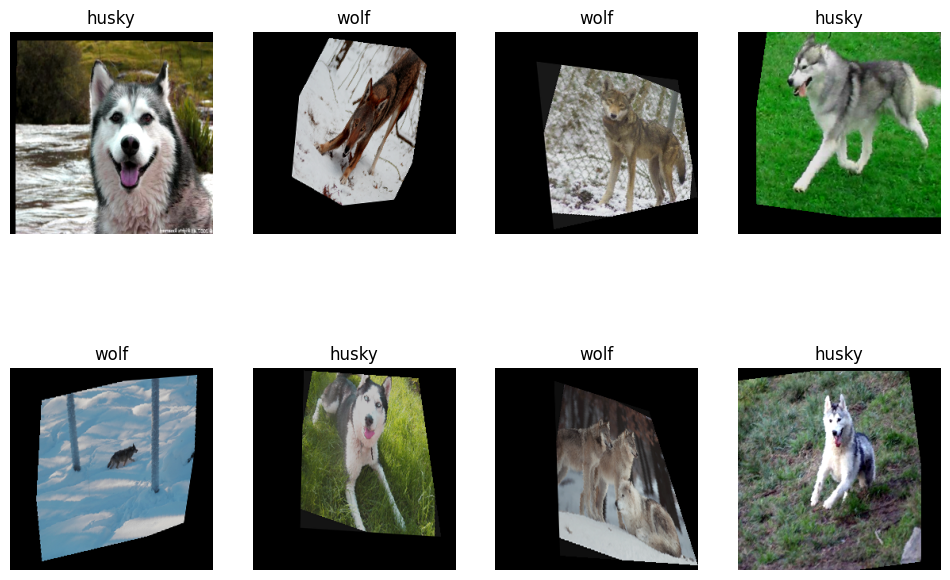

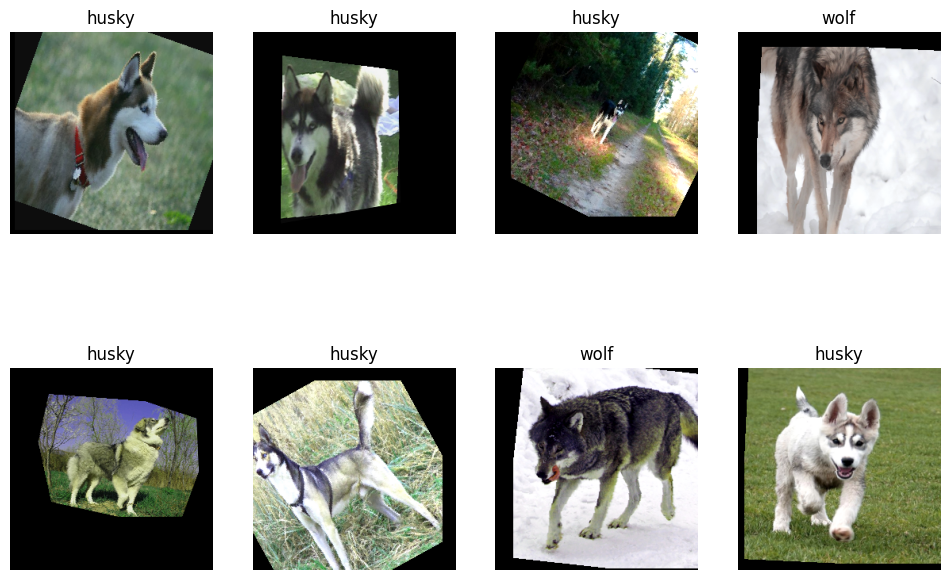

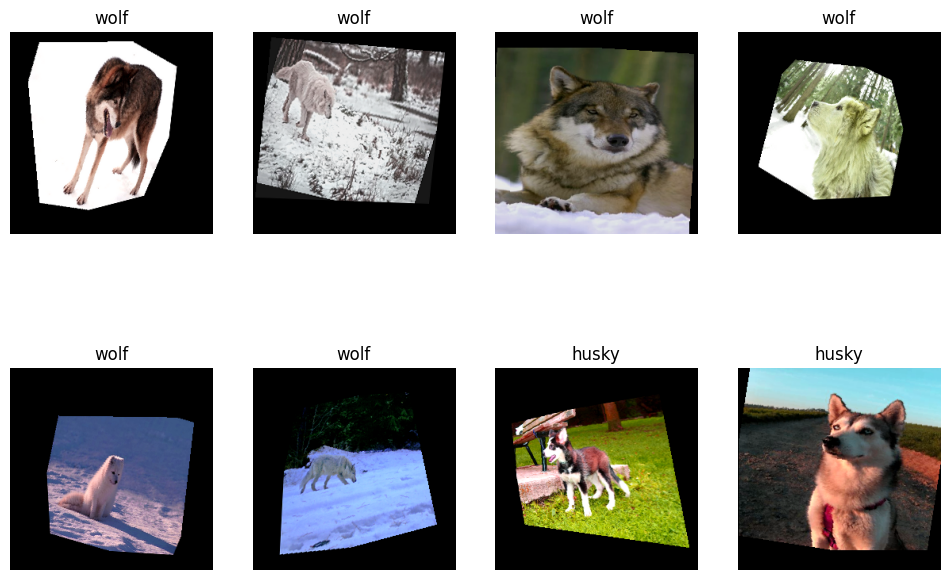

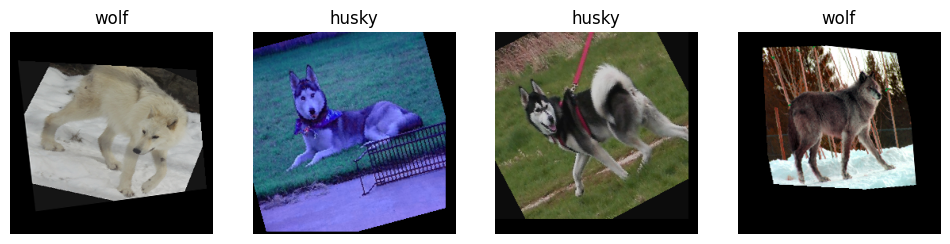

In [4]:
#Testing data loader
dataset = Wolf_Husky_Loader("C:\\Users\\ADMIN\\Downloads\\data\\data\\train\\")
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

for images, labels in dataloader:
    show_images(images, labels, dataset.classes)

## 2. Linear Approach 
### i.Model


In [5]:

class Wolf_Husky_LinearClassifier(nn.Module):
    def __init__(self):
        super(Wolf_Husky_LinearClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),  # Flatten input from 256x256x3 to 196608 (for images resized to 256x256 with 3 color channels
            nn.Linear(256*256*3, 1),  # Linear layer with a single output
            nn.Sigmoid()  # Sigmoid activation for binary classification
        )

    def forward(self, x):
        return self.model(x)

def linear_train(model, train_loader, val_loader, num_epochs=10, lr=0.001, save=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.BCELoss()  
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels.float().unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            predicted = (output > 0.5).float()
            correct_train += (predicted == labels.unsqueeze(1)).sum().item()
            total_train += labels.size(0)
        
        train_loss /= len(train_loader)
        train_accuracy = correct_train / total_train * 100
        
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                loss = criterion(output, labels.float().unsqueeze(1))
                val_loss += loss.item()
                
                predicted = (output > 0.5).float()
                correct_val += (predicted == labels.unsqueeze(1)).sum().item()
                total_val += labels.size(0)
        
        val_loss /= len(val_loader)
        val_accuracy = correct_val / total_val * 100
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
    
    if save:
        torch.save(model.state_dict(), "wolf_husky_linear_classifier.pth")
    return model

def linear_test(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            predicted = (output > 0.5).float()
            correct += (predicted == labels.float().unsqueeze(1)).sum().item()
            total += labels.size(0)
    
    accuracy = correct / total * 100
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy


### ii.Hyperparameter Tuning

In [6]:
TRAIN_RATIO = 0.8
NUM_EPOCHS = 10
BATCH_SIZES = [8, 16, 32]  
LEARNING_RATES = [0.01,0.001, 0.0005, 0.0001] 

In [7]:
def run_tuning():
    train_ratio = TRAIN_RATIO
    val_ratio = 1 - train_ratio

    train_size = int(train_ratio * len(dataloader))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataloader, [train_size, val_size])

    # keeping track best parameters
    best_accuracy = 0.0
    best_params = {}


    for batch_size, lr in itertools.product(BATCH_SIZES, LEARNING_RATES):
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = Wolf_Husky_LinearClassifier()

        
        print(f"\nTraining with batch size: {batch_size}, learning rate: {lr}")
        trained_model = linear_train(model, train_loader, val_loader, num_epochs=NUM_EPOCHS, lr=lr)

        accuracy = evaluate(trained_model, val_loader)
        print(f"Validation Accuracy: {accuracy:.2f}% with batch size: {batch_size}, learning rate: {lr}")

        # Track the best configuration
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'batch_size': batch_size, 'learning_rate': lr}

    print(f"\nBest Hyperparameters - Batch Size: {best_params['batch_size']}, Learning Rate: {best_params['learning_rate']}")
    print(f"Best Validation Accuracy: {best_accuracy:.2f}%")

def evaluate(model, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            predicted = (output > 0.5).float()
            correct += (predicted == labels.unsqueeze(1)).sum().item()
            total += labels.size(0)
    
    return correct / total * 100 

In [31]:
run_tuning()

ValueError: Sum of input lengths does not equal the length of the input dataset!

### iii.Training 

In [8]:
BATCH_SIZE = 8
LEARNING_RATE = 0.0005

In [10]:

batch_size = BATCH_SIZE
lr = LEARNING_RATE
train_ratio = TRAIN_RATIO
val_ratio = 1 - train_ratio

train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

model = Wolf_Husky_LinearClassifier()
linear_train(model, train_loader, val_loader, num_epochs=50, lr=lr,save=True)

Training set size: 80
Validation set size: 20
Epoch 1/50, Train Loss: 2.2706, Train Accuracy: 62.50%, Val Loss: 0.9908, Val Accuracy: 80.00%
Epoch 2/50, Train Loss: 2.5577, Train Accuracy: 60.00%, Val Loss: 6.3401, Val Accuracy: 55.00%
Epoch 3/50, Train Loss: 2.2629, Train Accuracy: 55.00%, Val Loss: 1.1812, Val Accuracy: 80.00%
Epoch 4/50, Train Loss: 1.4151, Train Accuracy: 66.25%, Val Loss: 1.3673, Val Accuracy: 80.00%
Epoch 5/50, Train Loss: 2.2172, Train Accuracy: 67.50%, Val Loss: 0.6401, Val Accuracy: 75.00%
Epoch 6/50, Train Loss: 1.4504, Train Accuracy: 72.50%, Val Loss: 1.2722, Val Accuracy: 80.00%
Epoch 7/50, Train Loss: 1.2869, Train Accuracy: 78.75%, Val Loss: 0.3602, Val Accuracy: 90.00%
Epoch 8/50, Train Loss: 1.4471, Train Accuracy: 67.50%, Val Loss: 0.3327, Val Accuracy: 95.00%
Epoch 9/50, Train Loss: 0.4030, Train Accuracy: 83.75%, Val Loss: 0.5066, Val Accuracy: 90.00%
Epoch 10/50, Train Loss: 0.7755, Train Accuracy: 80.00%, Val Loss: 0.2679, Val Accuracy: 90.00%
Epo

Wolf_Husky_LinearClassifier(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=196608, out_features=1, bias=True)
    (2): Sigmoid()
  )
)

### iv. To Test Linear Classifier

In [11]:
model = Wolf_Husky_LinearClassifier()
model.load_state_dict(torch.load('wolf_husky_linear_classifier.pth'))
dataset = Wolf_Husky_Loader("C:\\Users\\ADMIN\\Downloads\\data\\data\\train\\")
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
linear_test(model, dataloader)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_27084\3216180575.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('wolf_husky_linear_classifi

Test Accuracy: 88.00%


88.0

# 2. Neural Network CNN

### i.Model

In [12]:

class Wolf_Husky_Classifier(nn.Module):
    def __init__(self):
        super(Wolf_Husky_Classifier, self).__init__()
        self.model = nn.Sequential(
            # input --> 256x256x3
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1,stride=2),  #128x128x16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),    #64x64x16
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1,stride=2),  #32x32x32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),    #16x16x32
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), #16x16x64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  #8x8x64
            nn.Flatten(),
            nn.Linear(8*8*64, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

def train(model, train_loader, val_loader, num_epochs=10, lr=0.001,save=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):        
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels.float().unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()            

            predicted = (output > 0.5).float()
            correct_train += (predicted == labels.unsqueeze(1)).sum().item()
            total_train += labels.size(0)
        
        train_loss /= len(train_loader)
        train_accuracy = correct_train / total_train * 100
        
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                loss = criterion(output, labels.float().unsqueeze(1))
                val_loss += loss.item()
                
                predicted = (output > 0.5).float()
                correct_val += (predicted == labels.unsqueeze(1)).sum().item()
                total_val += labels.size(0)
        
        val_loss /= len(val_loader)
        val_accuracy = correct_val / total_val * 100
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
    
    if save:
        torch.save(model.state_dict(), "wolf_husky_classifier.pth")
    return model

def test(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            predicted = (output > 0.5).float()
            correct += (predicted == labels.float().unsqueeze(1)).sum().item()
            total += labels.size(0)
    
    accuracy = correct / total * 100
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

### ii.HyperParameter Tuning

In [13]:

TRAIN_RATIO = 0.8
NUM_EPOCHS = 50
BATCH_SIZES = [8, 16, 32]  
LEARNING_RATES = [0.001, 0.0005, 0.0001]  

In [14]:

def run_tuning():
    dataset = Wolf_Husky_Loader("C:\\Users\\ADMIN\\Downloads\\data\\data\\train\\")
    train_ratio = TRAIN_RATIO
    val_ratio = 1 - train_ratio

    train_size = int(train_ratio * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # keeping track best parameters
    best_accuracy = 0.0
    best_params = {}


    for batch_size, lr in itertools.product(BATCH_SIZES, LEARNING_RATES):
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = Wolf_Husky_Classifier()

        
        print(f"\nTraining with batch size: {batch_size}, learning rate: {lr}")
        trained_model = train(model, train_loader, val_loader, num_epochs=NUM_EPOCHS, lr=lr)

        accuracy = evaluate(trained_model, val_loader)
        print(f"Validation Accuracy: {accuracy:.2f}% with batch size: {batch_size}, learning rate: {lr}")

        # Track the best configuration
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'batch_size': batch_size, 'learning_rate': lr}

    print(f"\nBest Hyperparameters - Batch Size: {best_params['batch_size']}, Learning Rate: {best_params['learning_rate']}")
    print(f"Best Validation Accuracy: {best_accuracy:.2f}%")

def evaluate(model, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            predicted = (output > 0.5).float()
            correct += (predicted == labels.unsqueeze(1)).sum().item()
            total += labels.size(0)
    
    return correct / total * 100 

In [26]:
run_tuning()


Training with batch size: 8, learning rate: 0.001
Epoch 1/20, Train Loss: 0.6910, Train Accuracy: 58.75%, Val Loss: 0.6511, Val Accuracy: 50.00%
Epoch 2/20, Train Loss: 0.5920, Train Accuracy: 71.25%, Val Loss: 0.5152, Val Accuracy: 70.00%
Epoch 3/20, Train Loss: 0.3945, Train Accuracy: 86.25%, Val Loss: 0.3007, Val Accuracy: 90.00%
Epoch 4/20, Train Loss: 0.2570, Train Accuracy: 88.75%, Val Loss: 0.2012, Val Accuracy: 90.00%
Epoch 5/20, Train Loss: 0.2126, Train Accuracy: 92.50%, Val Loss: 0.1929, Val Accuracy: 90.00%
Epoch 6/20, Train Loss: 0.2196, Train Accuracy: 91.25%, Val Loss: 0.2434, Val Accuracy: 90.00%
Epoch 7/20, Train Loss: 0.1663, Train Accuracy: 95.00%, Val Loss: 0.1053, Val Accuracy: 95.00%
Epoch 8/20, Train Loss: 0.1406, Train Accuracy: 93.75%, Val Loss: 0.2345, Val Accuracy: 95.00%
Epoch 9/20, Train Loss: 0.1173, Train Accuracy: 93.75%, Val Loss: 0.2673, Val Accuracy: 95.00%
Epoch 10/20, Train Loss: 0.0961, Train Accuracy: 97.50%, Val Loss: 0.2881, Val Accuracy: 95.00

### iii. Training

In [15]:

TRAIN_RATIO = 0.8
BATCH_SIZE = 16
LEARNING_RATE = 0.0005


batch_size = BATCH_SIZE
lr = LEARNING_RATE
train_ratio = TRAIN_RATIO
val_ratio = 1 - train_ratio

train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

model = Wolf_Husky_Classifier()
train(model, train_loader, val_loader, num_epochs=50, lr=lr,save=True)


Training set size: 80
Validation set size: 20
Epoch 1/50, Train Loss: 0.7020, Train Accuracy: 48.75%, Val Loss: 0.7115, Val Accuracy: 60.00%
Epoch 2/50, Train Loss: 0.6442, Train Accuracy: 77.50%, Val Loss: 0.6434, Val Accuracy: 75.00%
Epoch 3/50, Train Loss: 0.6074, Train Accuracy: 80.00%, Val Loss: 0.6539, Val Accuracy: 75.00%
Epoch 4/50, Train Loss: 0.5151, Train Accuracy: 76.25%, Val Loss: 0.6095, Val Accuracy: 50.00%
Epoch 5/50, Train Loss: 0.5348, Train Accuracy: 71.25%, Val Loss: 0.6390, Val Accuracy: 65.00%
Epoch 6/50, Train Loss: 0.4601, Train Accuracy: 80.00%, Val Loss: 0.4888, Val Accuracy: 60.00%
Epoch 7/50, Train Loss: 0.4151, Train Accuracy: 78.75%, Val Loss: 0.5753, Val Accuracy: 70.00%
Epoch 8/50, Train Loss: 0.3282, Train Accuracy: 87.50%, Val Loss: 0.3104, Val Accuracy: 85.00%
Epoch 9/50, Train Loss: 0.4282, Train Accuracy: 80.00%, Val Loss: 0.3931, Val Accuracy: 85.00%
Epoch 10/50, Train Loss: 0.3225, Train Accuracy: 88.75%, Val Loss: 0.3541, Val Accuracy: 90.00%
Epo

Wolf_Husky_Classifier(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=4096, out_features=512, bias=True)
    (11): ReLU()
    (12): Linear(in_features=512, out_features=1, bias=True)
    (13): Sigmoid()
  )
)

### iv. Testing

In [16]:
model = Wolf_Husky_Classifier()
model.load_state_dict(torch.load('wolf_husky_classifier.pth'))
dataset = Wolf_Husky_Loader("C:\\Users\\ADMIN\\Downloads\\data\\data\\train\\")
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
test(model, dataloader)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_27084\843514803.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('wolf_husky_classifier.pth')

Test Accuracy: 94.00%


94.0

In [17]:
class Wolf_Husky_Classifier(nn.Module):
    def __init__(self):
        super(Wolf_Husky_Classifier, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, stride=2),  # 128x128x16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # 64x64x16
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=2),  # 32x32x32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # 16x16x32
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),  # 16x16x64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # 8x8x64
            nn.Flatten(),
            nn.Linear(8 * 8 * 64, 512),
            nn.ReLU(),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        features = self.model(x)
        output = self.classifier(features)
        return output

    def extract_features(self, x):
        with torch.no_grad():
            features = self.model(x)
        return features

In [18]:
import torch
from torch.utils.data import DataLoader
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = Wolf_Husky_Classifier()
#model.load_state_dict(torch.load("C:\\Users\\ADMIN\\Downloads\\wolf_husky_classifier.pth"))
model.eval()

dataset = Wolf_Husky_Loader(data_dir="C:\\Users\\ADMIN\\Downloads\\data\\data\\train\\")
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

features = []
labels = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

with torch.no_grad():
    for images, lbls in dataloader:
        images = images.to(device)
        extracted_features = model.extract_features(images)
        features.extend(extracted_features.cpu().numpy())  # Move to CPU and convert to numpy
        labels.extend(lbls.numpy())



In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

svm_classifier = SVC(kernel='poly', C=1.0)
svm_classifier.fit(X_train, y_train)

rf_classifier = RandomForestClassifier(n_estimators=100,criterion='gini')
rf_classifier.fit(X_train, y_train)

svm_predictions = svm_classifier.predict(X_test)
rf_predictions = rf_classifier.predict(X_test)

svm_accuracy = accuracy_score(y_test, svm_predictions)
rf_accuracy = accuracy_score(y_test, rf_predictions)

print(f"SVM Accuracy: {svm_accuracy * 100:.2f}%")
print(f"Random Forest Accuracy: {rf_accuracy * 100:.2f}%")


SVM Accuracy: 80.00%
Random Forest Accuracy: 80.00%


In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

knn_classifier = KNeighborsClassifier(n_neighbors=7)
knn_classifier.fit(X_train, y_train)

logistic_classifier = LogisticRegression(solver='sag')
logistic_classifier.fit(X_train, y_train)

knn_predictions = knn_classifier.predict(X_test)
logistic_predictions = logistic_classifier.predict(X_test)

knn_accuracy = accuracy_score(y_test, knn_predictions)
logistic_accuracy = accuracy_score(y_test, logistic_predictions)

print(f"KNN Accuracy: {knn_accuracy * 100:.2f}%")
print(f"Logistic Regression Accuracy: {logistic_accuracy * 100:.2f}%")


KNN Accuracy: 90.00%
Logistic Regression Accuracy: 75.00%


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2032.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [29]:
import requests
from PIL import Image
import io
import torch
from torchvision import transforms
import os

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

def classify_image(model, image_path, class_names):
    if image_path.startswith('http'):
        response = requests.get(image_path)
        img = Image.open(io.BytesIO(response.content))
    else:
        img = Image.open(image_path)

    img = transform(img).unsqueeze(0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    with torch.no_grad():
        img = img.to(device)
        output = model(img)
        predicted_class = (output > 0.5).item()
    
    return class_names[int(predicted_class)]

class_names = ["Wolf", "Husky"]
image_path = "C:\\Users\\ADMIN\\Downloads\\husky.webp"
print(f"Predicted class: {classify_image(model, image_path, class_names)}")


Predicted class: Husky
